<a href="https://colab.research.google.com/github/SnkhchyanV/NeuralNetworks/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc.

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})
from sklearn.datasets import load_digits
import os
from cv2 import imread, resize
import pandas as pd


In [2]:
def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(lambda img: img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: resize(img, (dimx, dimy)))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs



data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]


images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


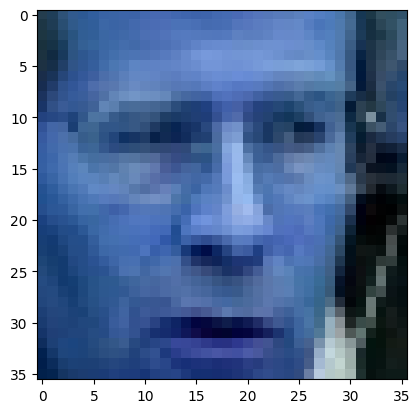

In [3]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent


The only problem is: how can we tell well-generated faces from bad?

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [5]:
print(data[np.random.randint(data.shape[0])].shape)

(36, 36, 3)


In [6]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               164480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 64)       16064     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       102464    
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

In [7]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

In [8]:
# Old one

# discriminator = Sequential()

# discriminator.add(L.InputLayer(IMG_SHAPE))
# discriminator.add(L.Conv2D(64, (3,3) ))
# discriminator.add(L.AveragePooling2D())
# discriminator.add(L.Conv2D(64, (3,3) ))
# discriminator.add(L.AveragePooling2D())
# discriminator.add(L.Conv2D(64, (3,3) ))
# discriminator.add(L.Conv2D(64, (3,3) ))
# discriminator.add(L.Flatten())
# discriminator.add(L.Dense(256,activation='tanh'))
# discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

#Updated one

discriminator = Sequential()

conv = lambda filters: L.Conv2D(
    kernel_size=3, filters=filters,
    padding='same', activation='relu'
)
discriminator.add(L.InputLayer(IMG_SHAPE)) # 36 * 36 * 3
discriminator.add(conv(16)) # 36 * 36 * 16
discriminator.add(conv(32)) # 36 * 36 * 32
discriminator.add(L.MaxPool2D()) # 18 * 18 * 32
discriminator.add(conv(64)) # 18 * 18 * 64
discriminator.add(conv(128)) # 18 * 18 * 128
discriminator.add(L.MaxPool2D()) # 9 * 9 * 128
discriminator.add(conv(256)) # 9 * 9 * 256
discriminator.add(conv(512)) # 9 * 9 * 512
discriminator.add(L.MaxPool2D(pool_size=3)) # 3 * 3 * 512
discriminator.add(L.GlobalAveragePooling2D()) # 1 * 1 * 512
discriminator.add(L.Flatten()) # 512
discriminator.add(L.Dense(256, activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        448       
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                  

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real

![img](https://github.com/SnkhchyanV/NeuralNetworks/blob/main/gan.png?raw=1)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* You can find useful tricks here https://github.com/soumith/ganhacks

In [9]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [10]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()
    return images


def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [11]:
disc_optimizer = tf.keras.optimizers.Adagrad(0.01)
gen_optimizer = tf.keras.optimizers.Adagrad(0.01)



1/1 [==============================] - 0s 19ms/step


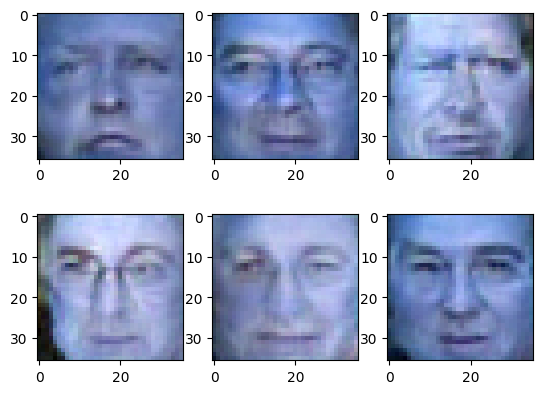

32/32 [==============================] - 0s 3ms/step


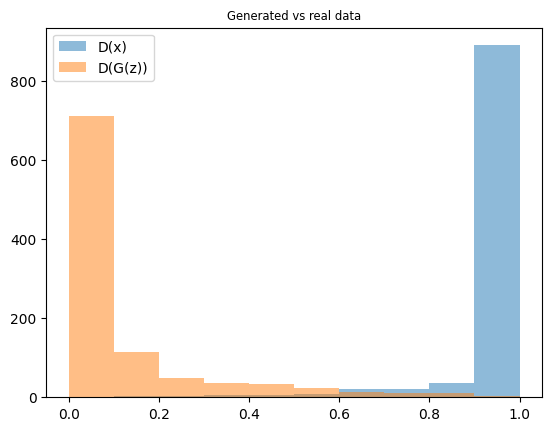

In [12]:
from IPython import display
from tqdm import tnrange
CODE_SIZE = 256

for epoch in tnrange(5000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)

    ########################
    #discriminator training#
    ########################
    for i in range(5):
      with tf.GradientTape() as tape:
        logp_real = discriminator(real_data)

        #logp_gen = <log P(real | gen(noise))
        ccs = tf.keras.losses.BinaryCrossentropy()

        generated_data = generator(noise)
        logp_gen = discriminator(generated_data)
        d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0], axis=0)

        #regularize
        d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

        #optimize
        disc_optimizer.minimize(d_loss, var_list=(discriminator.trainable_weights),tape=tape)

    ########################
    ###generator training###
    ########################

    with tf.GradientTape() as tape:
      generated_data = generator(noise)
      logp_gen = discriminator(generated_data)
      g_loss = -tf.reduce_mean(logp_gen[:, 1], axis=0)

      #optimize
      gen_optimizer.minimize(g_loss, var_list=(generator.trainable_variables), tape=tape)

    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)


4/4 [==============================] - 0s 3ms/step


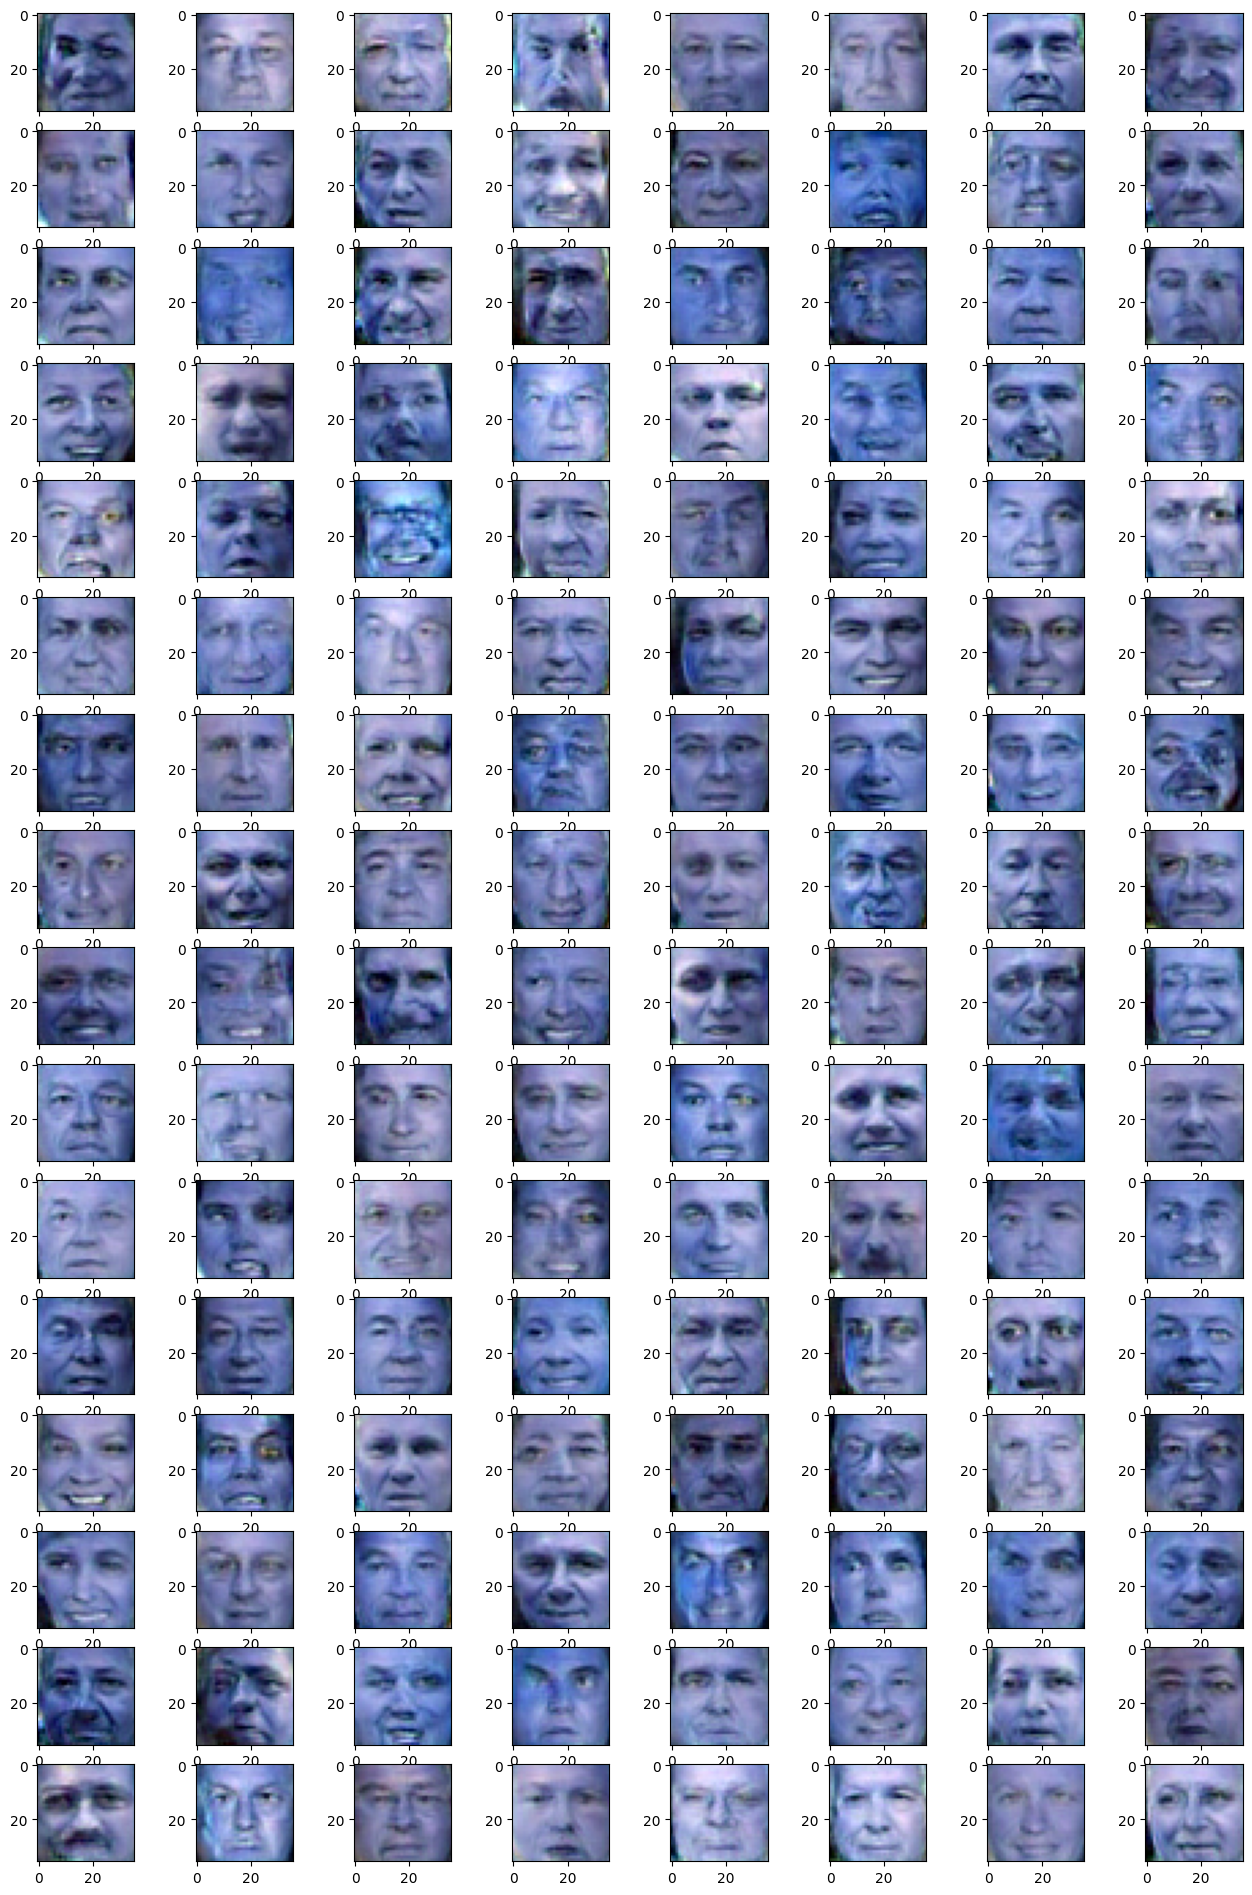

array([[[[0.588709  , 0.59151095, 0.5877369 ],
         [0.51566315, 0.49715716, 0.53114814],
         [0.2266052 , 0.32857588, 0.34778833],
         ...,
         [0.19938654, 0.2762446 , 0.35128224],
         [0.21819034, 0.26511756, 0.29814842],
         [0.18267554, 0.24844697, 0.27468354]],

        [[0.6096078 , 0.56898725, 0.56245023],
         [0.4245743 , 0.4037133 , 0.43929058],
         [0.1987907 , 0.28443384, 0.33000344],
         ...,
         [0.2131752 , 0.27234936, 0.36913478],
         [0.21898594, 0.23427075, 0.27944967],
         [0.16619995, 0.19909492, 0.22802329]],

        [[0.5537049 , 0.51368177, 0.5350461 ],
         [0.3764814 , 0.44018263, 0.44455183],
         [0.16093096, 0.34227338, 0.34799063],
         ...,
         [0.2034308 , 0.3025735 , 0.40245378],
         [0.17255203, 0.23227   , 0.2847438 ],
         [0.14490533, 0.17525774, 0.20165956]],

        ...,

        [[0.23864067, 0.25777903, 0.2499035 ],
         [0.27564737, 0.33933207, 0.3165475 ]

In [13]:
plt.figure(figsize=[16,24])
sample_images(16,8)

In [14]:
from google.colab import drive
drive.mount('/content/drive/')
file_path = '/content/drive/MyDrive/SavedModels/'
generator.save('/content/drive/MyDrive/SavedModels/GAN/Generator')
discriminator.save('/content/drive/MyDrive/SavedModels/GAN/Discriminator')

Mounted at /content/drive/
